## Name : Diksha Pardeshi
## USC ID : 7961073499
## GitHub username : dikshapardeshi


1. Decision Trees as Interpretable Models

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression , RidgeCV , LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import _tree, DecisionTreeClassifier
from xgboost import XGBRegressor


(a) Load the data


In [2]:
data_path = '../data/diagnosis.data'

df = pd.read_csv(data_path, encoding='utf-16', sep='\t',names=['Temperature','Nausea','Lumbar','Urine','Micturition','Urethra','Inflammation','Nephritis'],decimal=",")

df

Temperature Nausea Lumbar Urine Micturition Urethra Inflammation  \
0           35.5     no    yes    no          no      no           no   
1           35.9     no     no   yes         yes     yes          yes   
2           35.9     no    yes    no          no      no           no   
3           36.0     no     no   yes         yes     yes          yes   
4           36.0     no    yes    no          no      no           no   
..           ...    ...    ...   ...         ...     ...          ...   
115         41.4     no    yes   yes          no     yes           no   
116         41.5     no     no    no          no      no           no   
117         41.5    yes    yes    no         yes      no           no   
118         41.5     no    yes   yes          no     yes           no   
119         41.5     no    yes   yes          no     yes           no   

    Nephritis  
0          no  
1          no  
2          no  
3          no  
4          no  
..        ...  
115       yes  
116        no  
117       yes  
118       yes  
119       yes  

[120 rows x 8 columns]

(b) Build a decision tree on the whole data set and plot it

In [3]:
df = df.replace({'yes': 1, 'no': 0})

df_X = df.iloc[:, :6]
df_y = df.iloc[:, -2:]

classifier = tree.DecisionTreeClassifier(random_state=42)
classifier.fit(df_X, df_y)


/var/folders/qv/d4khr3997qn7z0cv4y4lwtk80000gn/T/ipykernel_27463/2830955855.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'yes': 1, 'no': 0})


DecisionTreeClassifier(random_state=42)

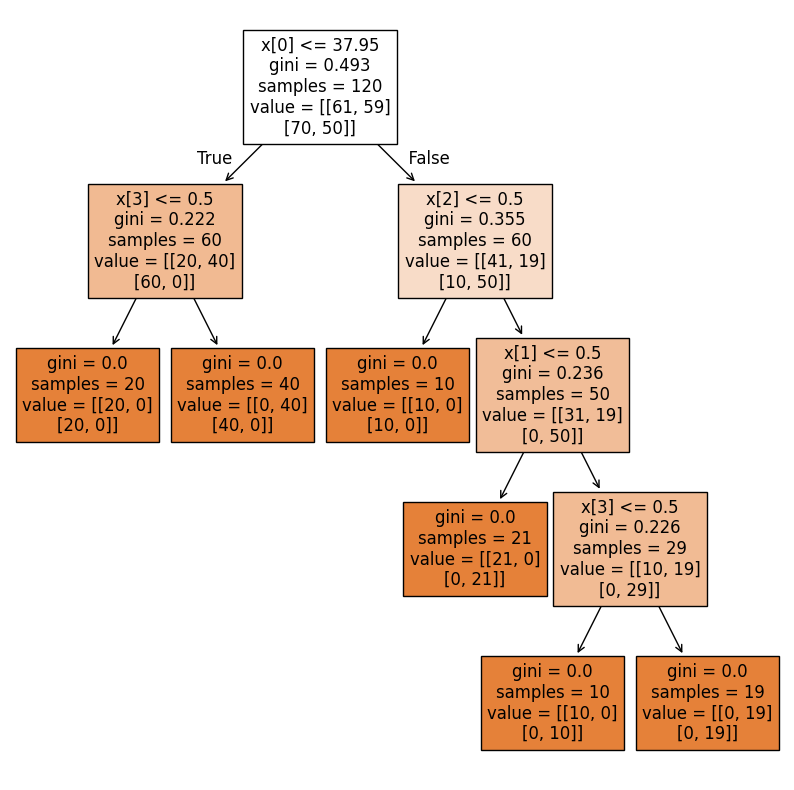

In [4]:
plt.figure(figsize=(10, 10))
tree.plot_tree(classifier, filled=True)
plt.show()


(c) Convert the decision rules into a set of IF-THEN rules.

In [5]:
## chatgpt prompt : How to traverse a decision tree to extract its values
tree_structure = classifier.tree_

feature_names = [
    df_X.columns[i] if i != _tree.TREE_UNDEFINED else "undefined"
    for i in tree_structure.feature
]

print("def decision_tree_logic({}):".format(", ".join(df_X.columns)))

def traverse_tree(node, depth):
    indent = "  " * depth
    if tree_structure.feature[node] != _tree.TREE_UNDEFINED:
        feature_name = feature_names[node]
        threshold_value = tree_structure.threshold[node]
        print("{}if {} <= {}:".format(indent, feature_name, threshold_value))
        traverse_tree(tree_structure.children_left[node], depth + 1)
        print("{}else:  # if {} > {}".format(indent, feature_name, threshold_value))
        traverse_tree(tree_structure.children_right[node], depth + 1)
    else:
        print("{}return [{}\n\t{}{}]".format(indent, tree_structure.value[node][0], indent, tree_structure.value[node][1]))

traverse_tree(0, 1)


def decision_tree_logic(Temperature, Nausea, Lumbar, Urine, Micturition, Urethra):
  if Temperature <= 37.95000076293945:
    if Urine <= 0.5:
      return [[1. 0.]
	      [1. 0.]]
    else:  # if Urine > 0.5
      return [[0. 1.]
	      [1. 0.]]
  else:  # if Temperature > 37.95000076293945
    if Lumbar <= 0.5:
      return [[1. 0.]
	      [1. 0.]]
    else:  # if Lumbar > 0.5
      if Nausea <= 0.5:
        return [[1. 0.]
	        [0. 1.]]
      else:  # if Nausea > 0.5
        if Urine <= 0.5:
          return [[1. 0.]
	          [0. 1.]]
        else:  # if Urine > 0.5
          return [[0. 1.]
	          [0. 1.]]


(d) Use cost-complexity pruning to find a minimal decision tree and a set of decision
rules with high interpretability.

Optimal ccp_alpha for pruning:  0.0


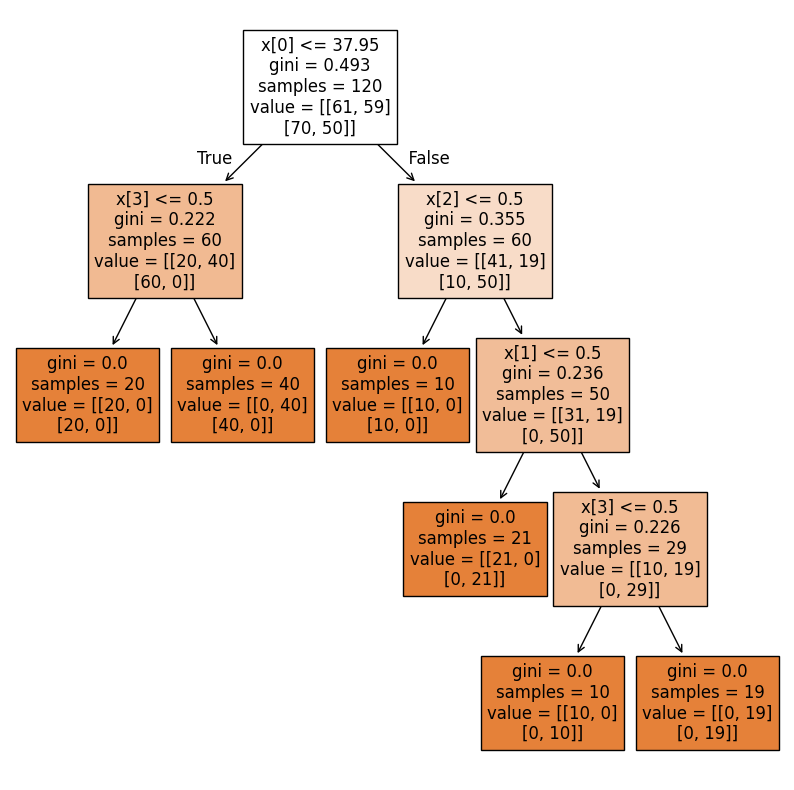

In [6]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV

decision_tree = DecisionTreeClassifier(random_state=42)

pruning_path = decision_tree.cost_complexity_pruning_path(df_X, df_y)
alpha_values, impurity_values = pruning_path.ccp_alphas, pruning_path.impurities

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42), 
    param_grid={'ccp_alpha': alpha_values}, 
    scoring='neg_mean_squared_error', 
    cv=5
)

grid_search.fit(df_X, df_y)

best_alpha = grid_search.best_params_['ccp_alpha']
print("Optimal ccp_alpha for pruning: ", best_alpha)

minimal_decision_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
minimal_decision_tree.fit(df_X, df_y)

plt.figure(figsize=(10, 10))
plot_tree(minimal_decision_tree, filled=True)
plt.show()


In [7]:
from sklearn.tree import _tree

decision_tree = minimal_decision_tree.tree_
features = [
    df_X.columns[i] if i != _tree.TREE_UNDEFINED else "undefined!"
    for i in decision_tree.feature
]

print("def decision_tree({}):".format(", ".join(df_X.columns)))

def traverse_tree(node_index, level):
    indentation = "  " * level
    if decision_tree.feature[node_index] != _tree.TREE_UNDEFINED:
        feature_name = features[node_index]
        threshold_value = decision_tree.threshold[node_index]
        print("{}if {} <= {}:".format(indentation, feature_name, threshold_value))
        traverse_tree(decision_tree.children_left[node_index], level + 1)
        print("{}else:  # if {} > {}".format(indentation, feature_name, threshold_value))
        traverse_tree(decision_tree.children_right[node_index], level + 1)
    else:
        print("{}return [{}\n\t{}{}]".format(indentation, decision_tree.value[node_index][0], indentation, decision_tree.value[node_index][1]))

traverse_tree(0, 1)


def decision_tree(Temperature, Nausea, Lumbar, Urine, Micturition, Urethra):
  if Temperature <= 37.95000076293945:
    if Urine <= 0.5:
      return [[1. 0.]
	      [1. 0.]]
    else:  # if Urine > 0.5
      return [[0. 1.]
	      [1. 0.]]
  else:  # if Temperature > 37.95000076293945
    if Lumbar <= 0.5:
      return [[1. 0.]
	      [1. 0.]]
    else:  # if Lumbar > 0.5
      if Nausea <= 0.5:
        return [[1. 0.]
	        [0. 1.]]
      else:  # if Nausea > 0.5
        if Urine <= 0.5:
          return [[1. 0.]
	          [0. 1.]]
        else:  # if Urine > 0.5
          return [[0. 1.]
	          [0. 1.]]


2. The LASSO and Boosting for Regression

a) Download the Communities and Crime data and Use the first 1495 rows of data as
the training set and the rest as the test set

In [8]:
import pandas as pd

DATA_PATH = '../data/communities.data'

column_names = [
    'state', 'county', 'community', 'communityname', 'fold', 'population',
    'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian', 
    'racePctHisp', 'agePct12t21', 'agePct12t29', 'agePct16t24', 
    'agePct65up', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 
    'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 
    'pctWRetire', 'medFamInc', 'perCapInc', 'whitePerCap', 
    'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 
    'HispPerCap', 'NumUnderPov', 'PctPopUnderPov', 
    'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 
    'PctUnemployed', 'PctEmploy', 'PctEmplManu', 
    'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf', 
    'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 
    'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 
    'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 
    'PctWorkMomYoungKids', 'PctWorkMom', 'NumIlleg', 
    'PctIlleg', 'NumImmig', 'PctImmigRecent', 
    'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10', 
    'PctRecentImmig', 'PctRecImmig5', 'PctRecImmig8', 
    'PctRecImmig10', 'PctSpeakEnglOnly', 'PctNotSpeakEnglWell', 
    'PctLargHouseFam', 'PctLargHouseOccup', 
    'PersPerOccupHous', 'PersPerOwnOccHous', 
    'PersPerRentOccHous', 'PctPersOwnOccup', 
    'PctPersDenseHous', 'PctHousLess3BR', 
    'MedNumBR', 'HousVacant', 'PctHousOccup', 
    'PctHousOwnOcc', 'PctVacantBoarded', 
    'PctVacMore6Mos', 'MedYrHousBuilt', 
    'PctHousNoPhone', 'PctWOFullPlumb', 
    'OwnOccLowQuart', 'OwnOccMedVal', 
    'OwnOccHiQuart', 'RentLowQ', 'RentMedian', 
    'RentHighQ', 'MedRent', 'MedRentPctHousInc', 
    'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg', 
    'NumInShelters', 'NumStreet', 'PctForeignBorn', 
    'PctBornSameState', 'PctSameHouse85', 
    'PctSameCity85', 'PctSameState85', 'LemasSwornFT', 
    'LemasSwFTPerPop', 'LemasSwFTFieldOps', 
    'LemasSwFTFieldPerPop', 'LemasTotalReq', 
    'LemasTotReqPerPop', 'PolicReqPerOffic', 
    'PolicPerPop', 'RacialMatchCommPol', 
    'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 
    'PctPolicAsian', 'PctPolicMinor', 
    'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz', 
    'PolicAveOTWorked', 'LandArea', 'PopDens', 
    'PctUsePubTrans', 'PolicCars', 'PolicOperBudg', 
    'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 
    'LemasPctOfficDrugUn', 'PolicBudgPerPop', 
    'ViolentCrimesPerPop'
]

community_data = pd.read_csv(DATA_PATH, names=column_names, na_values="?")

train_data = community_data[:1495]
test_data = community_data[1495:]



In [9]:
train_data.head()

state  county  community        communityname  fold  population  \
0      8     NaN        NaN         Lakewoodcity     1        0.19   
1     53     NaN        NaN          Tukwilacity     1        0.00   
2     24     NaN        NaN         Aberdeentown     1        0.00   
3     34     5.0    81440.0  Willingborotownship     1        0.04   
4     42    95.0     6096.0    Bethlehemtownship     1        0.01   

   householdsize  racepctblack  racePctWhite  racePctAsian  ...  LandArea  \
0           0.33          0.02          0.90          0.12  ...      0.12   
1           0.16          0.12          0.74          0.45  ...      0.02   
2           0.42          0.49          0.56          0.17  ...      0.01   
3           0.77          1.00          0.08          0.12  ...      0.02   
4           0.55          0.02          0.95          0.09  ...      0.04   

   PopDens  PctUsePubTrans  PolicCars  PolicOperBudg  LemasPctPolicOnPatr  \
0     0.26            0.20       0.06           0.04                  0.9   
1     0.12            0.45        NaN            NaN                  NaN   
2     0.21            0.02        NaN            NaN                  NaN   
3     0.39            0.28        NaN            NaN                  NaN   
4     0.09            0.02        NaN            NaN                  NaN   

   LemasGangUnitDeploy  LemasPctOfficDrugUn  PolicBudgPerPop  \
0                  0.5                 0.32             0.14   
1                  NaN                 0.00              NaN   
2                  NaN                 0.00              NaN   
3                  NaN                 0.00              NaN   
4                  NaN                 0.00              NaN   

   ViolentCrimesPerPop  
0                 0.20  
1                 0.67  
2                 0.43  
3                 0.12  
4                 0.03  

[5 rows x 128 columns]

(b) The data set has missing values. Use a data imputation technique to deal with
the missing values in the data set. The data description mentions some features
are nonpredictive. Ignore those features

In [10]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

train_subset = train_data.iloc[:, 5:].copy()
test_subset = test_data.iloc[:, 5:].copy()

mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

mean_imputer.fit(train_subset)
train_subset_imputed = pd.DataFrame(mean_imputer.transform(train_subset), columns=train_subset.columns)

mean_imputer.fit(test_subset)
test_subset_imputed = pd.DataFrame(mean_imputer.transform(test_subset), columns=test_subset.columns)

df_train = train_subset_imputed
df_test = test_subset_imputed


In [11]:
pip install Jinja2


Note: you may need to restart the kernel to use updated packages.


c) Plot a correlation matrix for the features in the data set

In [12]:
df_combined_ = pd.concat([df_train, df_test], ignore_index=True)
correlation_matrix = df_combined_.corr()
correlation_matrix.style.background_gradient(cmap = 'seismic')

<Axes: >

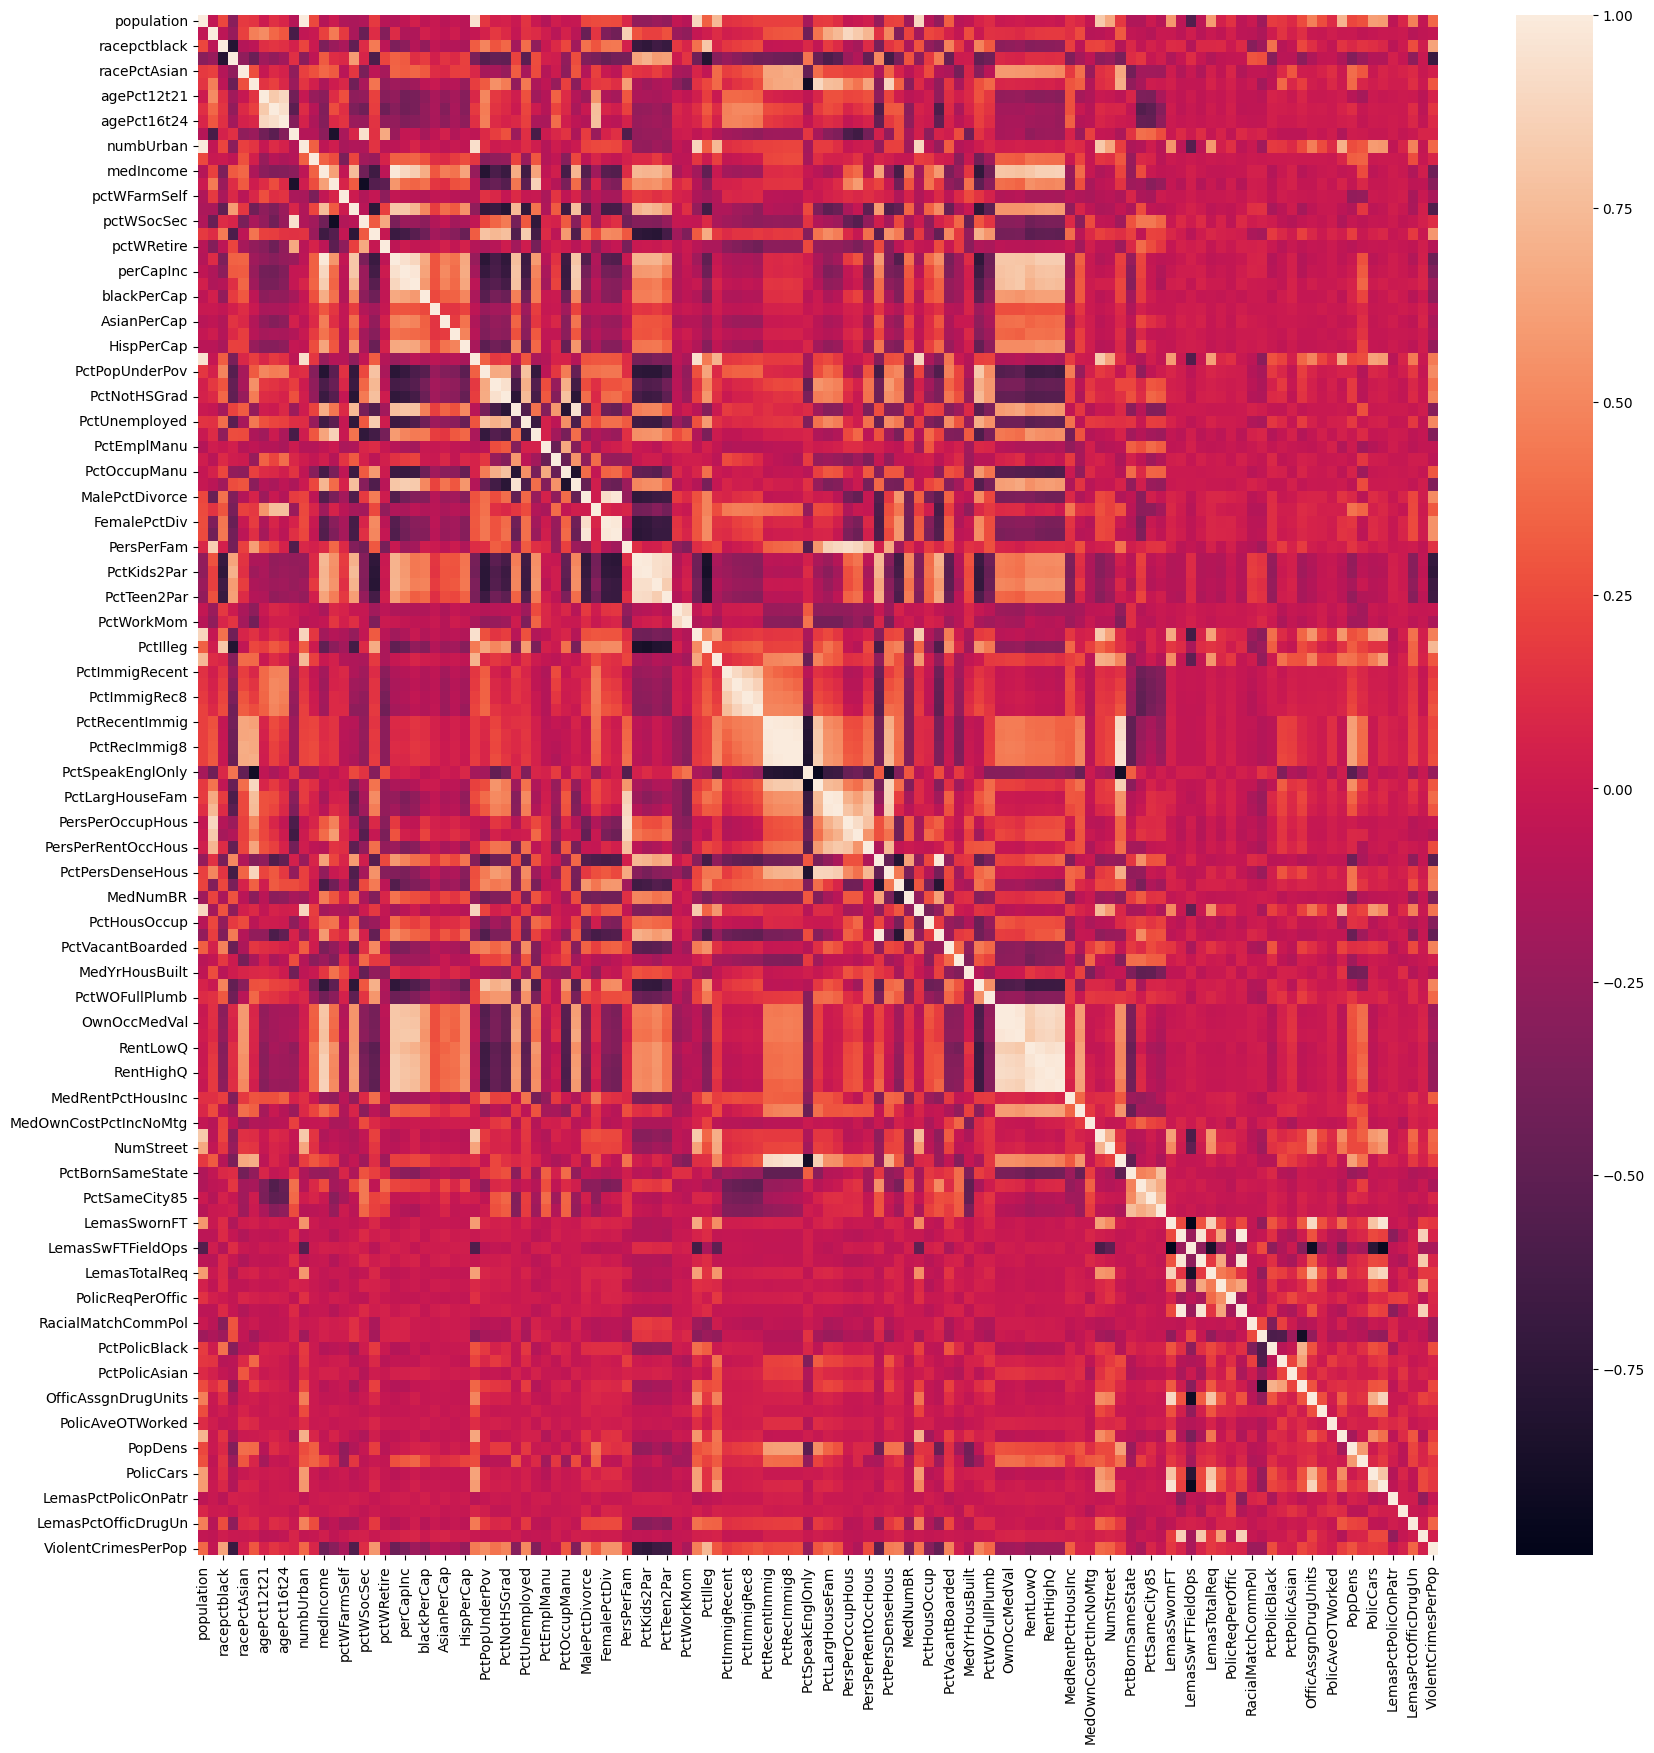

In [13]:
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix)

(d) Calculate the Coefficient of Variation CV for each feature, where CV = s
/m, in
which s is sample standard deviation and m is sample mean

In [14]:
df_summary = df_combined_.describe()
Coeff_of_variation = df_summary.loc['std']/df_summary.loc['mean']
print(Coeff_of_variation)

population             2.203503
householdsize          0.353298
racepctblack           1.410920
racePctWhite           0.323782
racePctAsian           1.359162
                         ...   
LemasPctPolicOnPatr    0.126642
LemasGangUnitDeploy    0.370311
LemasPctOfficDrugUn    2.555266
PolicBudgPerPop        0.339119
ViolentCrimesPerPop    0.979015
Length: 123, dtype: float64


(e) Pick b√128c features with highest CV , and make scatter plots and box plots for
them. Can you draw conclusions about significance of those features, just by the
scatter plots

In [15]:
num_features = int(math.sqrt(128))
highest_CV = Coeff_of_variation.sort_values(ascending = False)[:num_features]
highest_CV

NumStreet              4.407702
NumInShelters          3.485481
NumIlleg               2.994196
NumImmig               2.900497
LemasPctOfficDrugUn    2.555266
NumUnderPov            2.304970
population             2.203503
numbUrban              2.001744
HousVacant             1.958780
LandArea               1.678031
racePctHisp            1.614278
dtype: float64

Scatter plot

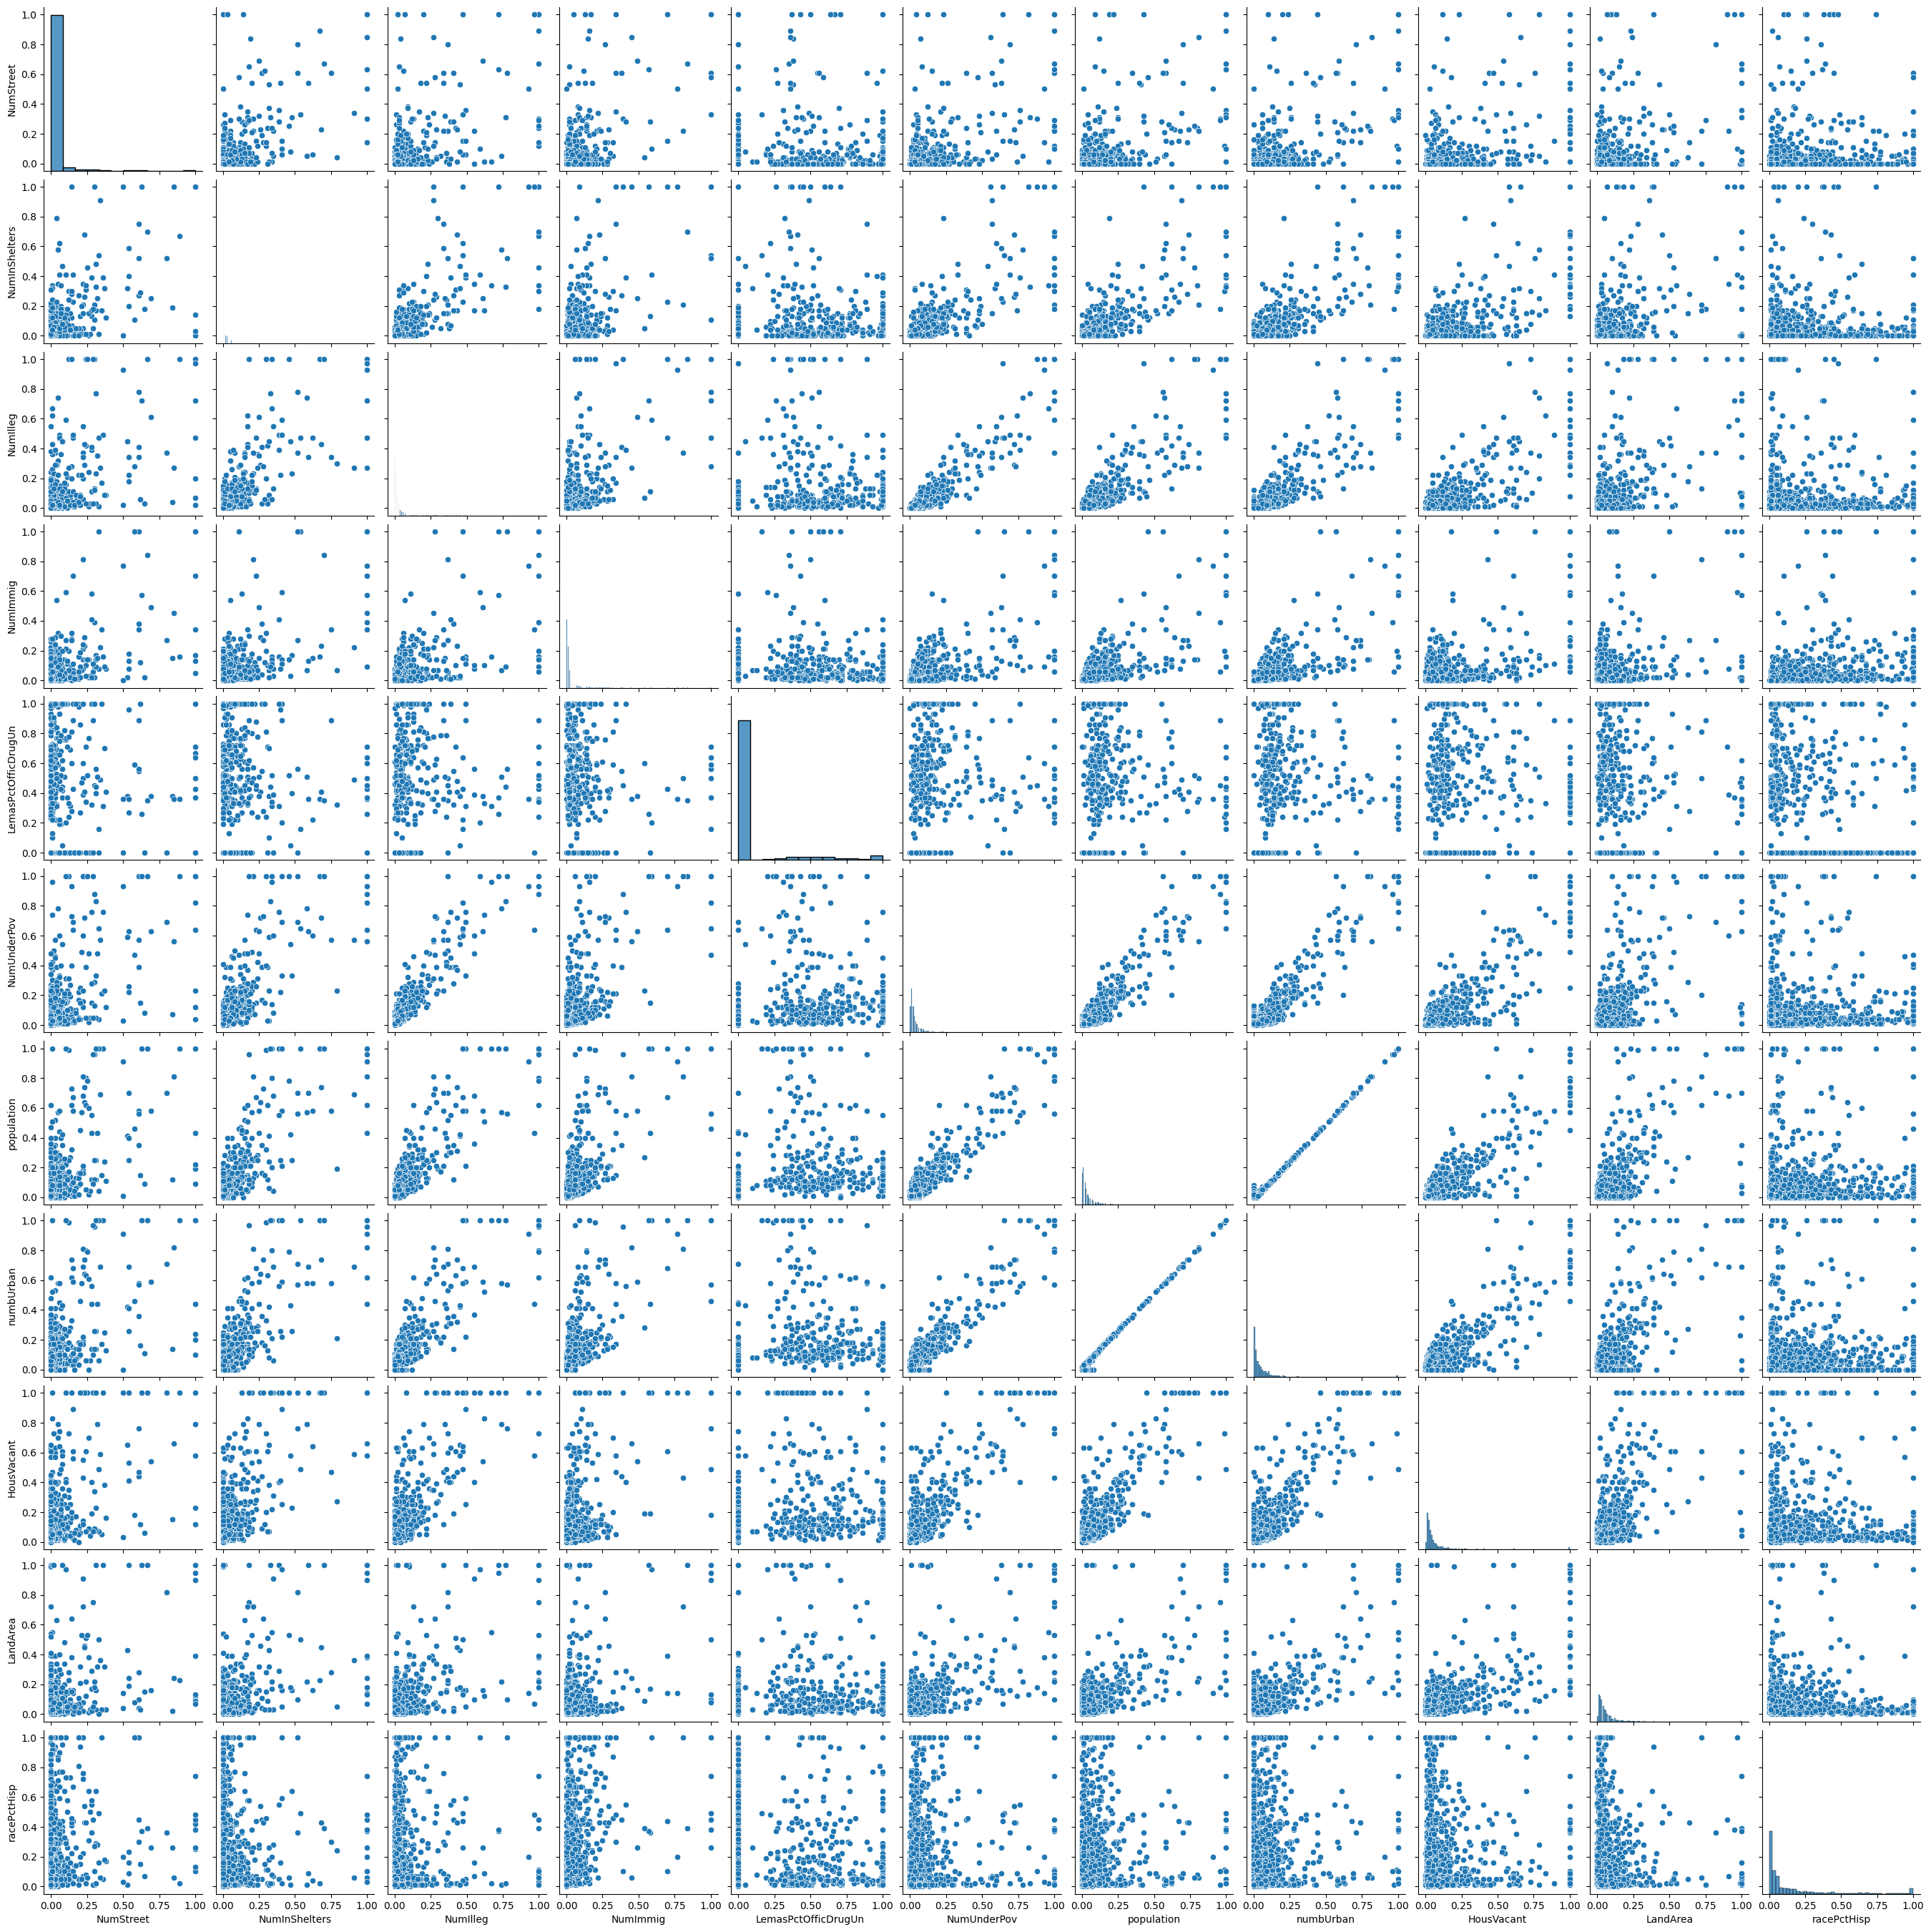

In [16]:
columns_to_plot = list(highest_CV.index)  
sns.pairplot(df_combined_[columns_to_plot])

Box plot

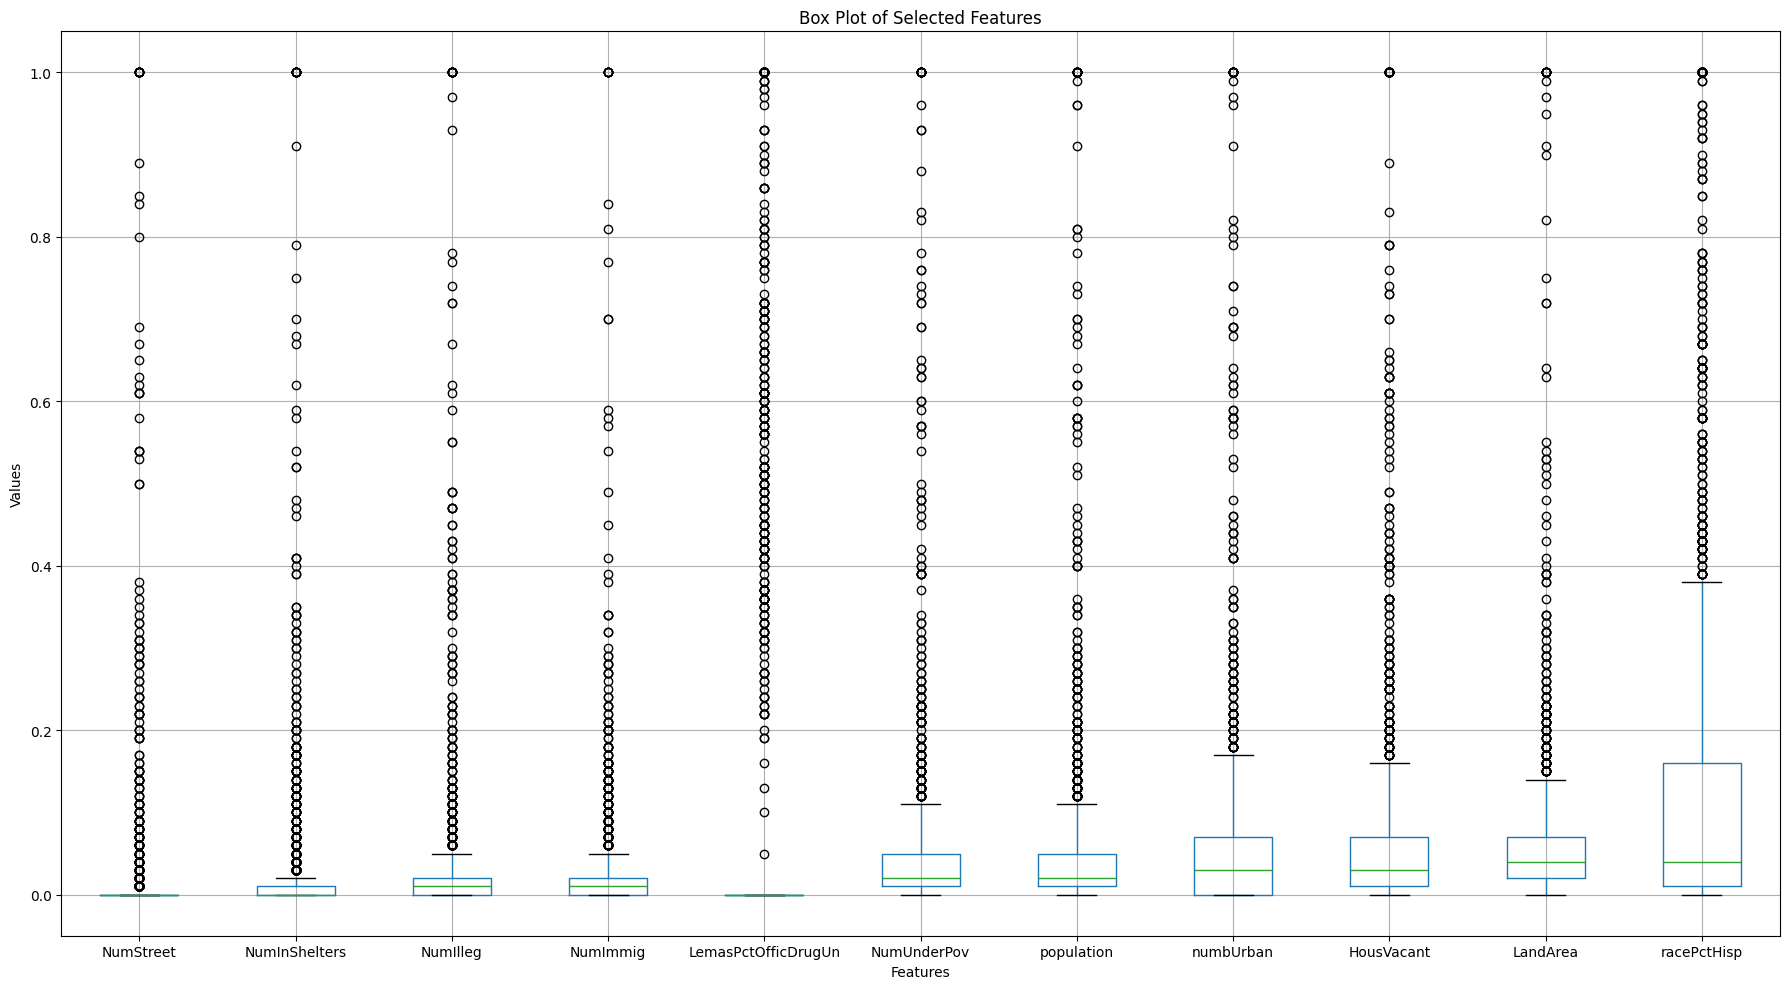

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))

df_combined_[highest_CV.index].boxplot()

plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Box Plot of Selected Features')
plt.tight_layout()
plt.show()


Conclusion : 

Based on the scatterplot and boxplot above, it appears that the variables NumStreet and LemasPctOfficDrugUn have low coefficients of variation, indicating that they can yield more accurate estimates. However, I think that the scatterplots alone are insufficient for making definitive conclusions, and we should seek additional evidence to support any final determinations.

(f) Fit a linear model using least squares to the training set and report the test error

In [18]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

X_train = df_train.iloc[:, :-1]  
y_train = df_train.iloc[:, -1]   
X_test = df_test.iloc[:, :-1]    
y_test = df_test.iloc[:, -1]     

X_train_const = sm.add_constant(X_train)

ols_model = sm.OLS(y_train, X_train_const).fit()

X_test_const = sm.add_constant(X_test)

predictions = ols_model.predict(X_test_const)

mse_value = round(mean_squared_error(y_test, predictions), 5)

print("Mean Squared Error for test: ", mse_value)


Mean Squared Error for test:  0.01811


(g) Fit a ridge regression model on the training set, with λ chosen by cross-validation.
Report the test error obtained

In [19]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

ridge_model = RidgeCV(cv=KFold(n_splits=5, random_state=42, shuffle=True)).fit(X_train, y_train.values)

predictions = ridge_model.predict(X_test)

mse_value = mean_squared_error(y_test, predictions)

print("Alpha(λ) chosen by Cross Validation: ", ridge_model.alpha_)
print("Test Error with Linear Regression while using Ridge Regression: ", mse_value)


Alpha(λ) chosen by Cross Validation:  10.0
Test Error with Linear Regression while using Ridge Regression:  0.017433089174599282


(h) Fit a LASSO model on the training set, with λ chosen by cross-validation. Report
the test error obtained, along with a list of the variables selected by the model.
Repeat with standardized4 features. Report the test error for both cases and
compare them

In [20]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pandas as pd

def run_lasso_regression(X_train, y_train, X_test, y_test, normalize=False):
    selected_variables = []
    if normalize:
        scaler = StandardScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    
    lasso_model = LassoCV(cv=KFold(n_splits=5, random_state=42, shuffle=True)).fit(X_train, y_train.values.ravel())
    
    
    predictions = lasso_model.predict(X_test)
    
    for index, coefficient in enumerate(lasso_model.coef_):
        if coefficient != 0:
            selected_variables.append((X_train.columns[index], coefficient))
    
    mse_value = mean_squared_error(y_test, predictions)
    
    best_alpha = lasso_model.alpha_
    
    return best_alpha, mse_value, selected_variables


alpha, mse, important_vars = run_lasso_regression(X_train, y_train, X_test, y_test, normalize=False)

print("Optimal alpha for LassoCV: ", alpha)
print("Mean Squared Error for Lasso without normalization: ", mse)
print("Number of selected variables: ", len(important_vars))
print("Selected variables and coefficients:")
important_vars


/opt/anaconda3/envs/dsci552/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008427836134742961, tolerance: 0.006920690568561872
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/dsci552/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008616502154382033, tolerance: 0.006920690568561872
  model = cd_fast.enet_coordinate_descent_gram(


Optimal alpha for LassoCV:  0.00010831930127505137
Mean Squared Error for Lasso without normalization:  0.017749347691314338
Number of selected variables:  77
Selected variables and coefficients:


[('racepctblack', np.float64(0.27247983279268984)),
 ('racePctAsian', np.float64(-0.016861107797085207)),
 ('agePct12t21', np.float64(0.07145181529352249)),
 ('agePct12t29', np.float64(-0.27832248364869155)),
 ('agePct65up', np.float64(0.0008913986149601073)),
 ('pctUrban', np.float64(0.04072680260306079)),
 ('pctWWage', np.float64(-0.0890767428291045)),
 ('pctWFarmSelf', np.float64(0.027749389214068127)),
 ('pctWInvInc', np.float64(-0.10369672155583899)),
 ('pctWSocSec', np.float64(0.054021990772338456)),
 ('pctWPubAsst', np.float64(0.04009990880845388)),
 ('pctWRetire', np.float64(-0.10916654442064717)),
 ('whitePerCap', np.float64(-0.06301724998976319)),
 ('blackPerCap', np.float64(-0.021714065519081557)),
 ('indianPerCap', np.float64(-0.0314930493851977)),
 ('AsianPerCap', np.float64(0.029126974894686984)),
 ('OtherPerCap', np.float64(0.023096358152077893)),
 ('HispPerCap', np.float64(0.024857739584907734)),
 ('PctPopUnderPov', np.float64(-0.14526403855194342)),
 ('PctLess9thGrade'

In [21]:
best_lambda, test_mse, selected_features = run_lasso_regression(X_train, y_train, X_test, y_test, normalize=True)

print("Optimal lambda from LassoCV: ", best_lambda)
print("Mean Squared Error for Lasso with normalization: ", test_mse)
print("Count of selected features: ", len(selected_features))
print("Selected features and their coefficients:")
selected_features


Optimal lambda from LassoCV:  0.0006189604623293166
Mean Squared Error for Lasso with normalization:  0.017860121015142182
Count of selected features:  76
Selected features and their coefficients:


/opt/anaconda3/envs/dsci552/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008439190873971825, tolerance: 0.006920690568561872
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/dsci552/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008515954419856087, tolerance: 0.006920690568561872
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/dsci552/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00834543228507556, tolerance: 0.006920690568561872
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/dsci552/lib/python

[('population', np.float64(-0.0003636133561909785)),
 ('racepctblack', np.float64(0.06913277662176802)),
 ('racePctAsian', np.float64(-0.00203514015474747)),
 ('agePct12t21', np.float64(0.012950231751532279)),
 ('agePct12t29', np.float64(-0.04379260926269081)),
 ('pctUrban', np.float64(0.017190977805659792)),
 ('pctWWage', np.float64(-0.014801389496938178)),
 ('pctWFarmSelf', np.float64(0.004911759989307425)),
 ('pctWInvInc', np.float64(-0.02188033642358871)),
 ('pctWSocSec', np.float64(0.010291707621746669)),
 ('pctWPubAsst', np.float64(0.007741557680785798)),
 ('pctWRetire', np.float64(-0.01801255386351576)),
 ('whitePerCap', np.float64(-0.010432690008436394)),
 ('blackPerCap', np.float64(-0.003920979635941271)),
 ('indianPerCap', np.float64(-0.0053535989945578495)),
 ('AsianPerCap', np.float64(0.005516253751416425)),
 ('OtherPerCap', np.float64(0.004035565234642982)),
 ('HispPerCap', np.float64(0.00458775180773781)),
 ('PctPopUnderPov', np.float64(-0.029806298857301083)),
 ('PctLess

Comparison : 

Mean Squared Error for Lasso with normalization:  0.01782421487123247

Mean Squared Error for Lasso without normalization:  0.017780294238112625

 the slight difference in MSE tells us that normalizing the features did not provide a significant advantage, rather the eroor increased when we normalized the model.


(i) Fit a PCR model on the training set, with M (the number of principal compo-
nents) chosen by cross-validation. Report the test error obtained.

In [22]:
def count_components(x_train, y_train):
    scores = []
    total_components = len(x_train.columns)
    
    for n in range(1, total_components + 1):
        pipeline = make_pipeline(PCA(n_components=n), LinearRegression(fit_intercept=True))
        cv_scores = cross_val_score(pipeline, x_train, y_train, cv=KFold(n_splits=5, random_state=42, shuffle=True), scoring='neg_mean_squared_error')
        average_score = -np.mean(cv_scores)  
        scores.append(average_score)
    
    optimal_components = np.argmin(scores) + 1
    return optimal_components, scores[optimal_components - 1]

def perform_PCR(optimal_components, x_train, y_train):
    pcr_model = make_pipeline(PCA(n_components=optimal_components), LinearRegression(fit_intercept=True))
    pcr_model.fit(x_train, y_train)
    predictions = pcr_model.predict(X_test)
    mse_value = mean_squared_error(y_test, predictions)
    return mse_value

optimal_components, train_mse = count_components(X_train, y_train)
test_mse = perform_PCR(optimal_components, X_train, y_train)

print("Chosen number of principal components (M):", optimal_components)
print("Test MSE with PCR using M ({}): {:.5f}".format(optimal_components, test_mse))
print("Train MSE with PCR using M ({}): {:.5f}".format(optimal_components, train_mse))


Chosen number of principal components (M): 45
Test MSE with PCR using M (45): 0.01831
Train MSE with PCR using M (45): 0.01992


(j) In this section, we would like to fit a boosting tree to the data. As in classification
trees, one can use any type of regression at each node to build a multivariate
regression tree. Because the number of variables is large in this problem, one
can use L1-penalized regression at each node. Such a tree is called L1 penalized
gradient boosting tree. You can use XGBoost5 to fit the model tree. Determine
α (the regularization term) using cross-validation.


In [23]:
def find_optimal_alpha(x_train, y_train):
    mse_scores = []
    alpha_values = range(0, 11)
    
    for alpha in alpha_values:
        model = XGBRegressor(reg_alpha=alpha, random_state=42)
        cv_scores = cross_val_score(model, x_train, y_train, cv=KFold(n_splits=5, random_state=42, shuffle=True), scoring='neg_mean_squared_error')
        mse_scores.append(np.mean(np.abs(cv_scores)))

    optimal_index = np.argmin(mse_scores)
    return alpha_values[optimal_index], mse_scores[optimal_index]

optimal_alpha, mse_train = find_optimal_alpha(X_train, y_train)
print("Optimal Alpha found through cross-validation: ", optimal_alpha)
print("Mean Squared Error on training data using XGBoost with the selected alpha: ", mse_train)

def evaluate_xgboost_mse(optimal_alpha):
    xgboost_model = XGBRegressor(alpha=optimal_alpha, random_state=42)
    xgboost_model.fit(X_train, y_train)
    predictions = xgboost_model.predict(X_test)
    test_mse = mean_squared_error(y_test, predictions)
    return test_mse

mse_test_xgboost = evaluate_xgboost_mse(optimal_alpha)
print("Mean Squared Error on test data using XGBoost with the chosen alpha: ", mse_test_xgboost)


Optimal Alpha found through cross-validation:  5
Mean Squared Error on training data using XGBoost with the selected alpha:  0.020897794376897958
Mean Squared Error on test data using XGBoost with the chosen alpha:  0.016300629506157963


References : 

https://www.geeksforgeeks.org/decision-tree/

https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LassoCV.html

https://scikit-learn.org/0.15/modules/generated/sklearn.linear_model.RidgeCV.html

https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html

https://www.analyticsvidhya.com/blog/2021/08/decision-tree-algorithm/

https://machinelearningmastery.com/statistical-imputation-for-missing-values-in-machine-learning/

https://docs.python.org/3/library/math.html

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.boxplot.html

https://www.statology.org/principal-components-regression-in-python/

https://www.geeksforgeeks.org/principal-component-regression-pcr/

https://thedatascientist.com/gradient-boosted-trees-python/